# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import time

train_data = pd.read_csv('train.csv')

# Remove oversampling
claimed = train_data[train_data['is_claim'] == 1]
not_claimed = train_data[train_data['is_claim'] == 0]
sample_size = min(len(claimed), len(not_claimed))
train_data = pd.concat([claimed.sample(n=sample_size), not_claimed.sample(n=sample_size)])

print(train_data.head())

      policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster   
51026   ID51027       0.247789        0.00             0.548077          C10  \
12711   ID12712       1.072670        0.08             0.461538           C2   
4106    ID04107       0.062421        0.00             0.480769           C4   
46371   ID46372       1.101938        0.01             0.480769           C7   
11936   ID11937       0.396818        0.05             0.442308           C2   

       population_density  make segment model fuel_type  ... is_brake_assist   
51026               73430     1       A    M1       CNG  ...              No  \
12711               27003     1      B2    M6    Petrol  ...             Yes   
4106                21622     1       A    M1       CNG  ...              No   
46371                6112     3      C2    M4    Diesel  ...             Yes   
11936               27003     2       A    M3    Petrol  ...              No   

      is_power_door_locks is_central_l

We had to have the same number of claims and not claims to avoid **oversampling**

### Let's check if there are columns with missing values
### And change the non-numeric columns to numeric

In [3]:
cols_with_na = train_data.columns[train_data.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

train_data['policy_id'] = train_data['policy_id'].apply(lambda x: x.replace('ID', ''))
train_data['area_cluster'] = train_data['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data = pd.get_dummies(train_data, columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data['model'] = train_data['model'].apply(lambda x: x.replace('M', ''))
train_data = train_data.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data['transmission_type'] = encoder.fit_transform(train_data['transmission_type'])

train_data['max_torque'] = train_data['max_torque'].apply(lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data['max_power'] = train_data['max_power'].apply(lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))


Columns with missing values: []


As we can see, there are no missing values in our data set

### Let's now get some more general information of our features

In [21]:
print(train_data.describe())

       policy_tenure   age_of_car  age_of_policyholder  population_density   
count    7496.000000  7496.000000          7496.000000         7496.000000  \
mean        0.665598     0.066826             0.473151        18124.893276   
std         0.407349     0.054818             0.124837        16925.507386   
min         0.002801     0.000000             0.288462          290.000000   
25%         0.272972     0.020000             0.375000         6112.000000   
50%         0.679824     0.060000             0.461538         8794.000000   
75%         1.062395     0.110000             0.548077        27003.000000   
max         1.386520     0.420000             0.951923        73430.000000   

              make     max_torque      max_power      airbags  displacement   
count  7496.000000    7496.000000    7496.000000  7496.000000   7496.000000  \
mean      1.761873  444872.549360  403494.844450     3.135806   1167.026014   
std       1.139148  181037.909914  115799.867806     1.83639

In [ ]:
%matplotlib inline

sb.pairplot(train_data)

After some investigating, there are no major outliers that require work.
There are some variables that seem to have no correlation with the `is_claim` feature

### Now let's check what features have no correlation with the test feature

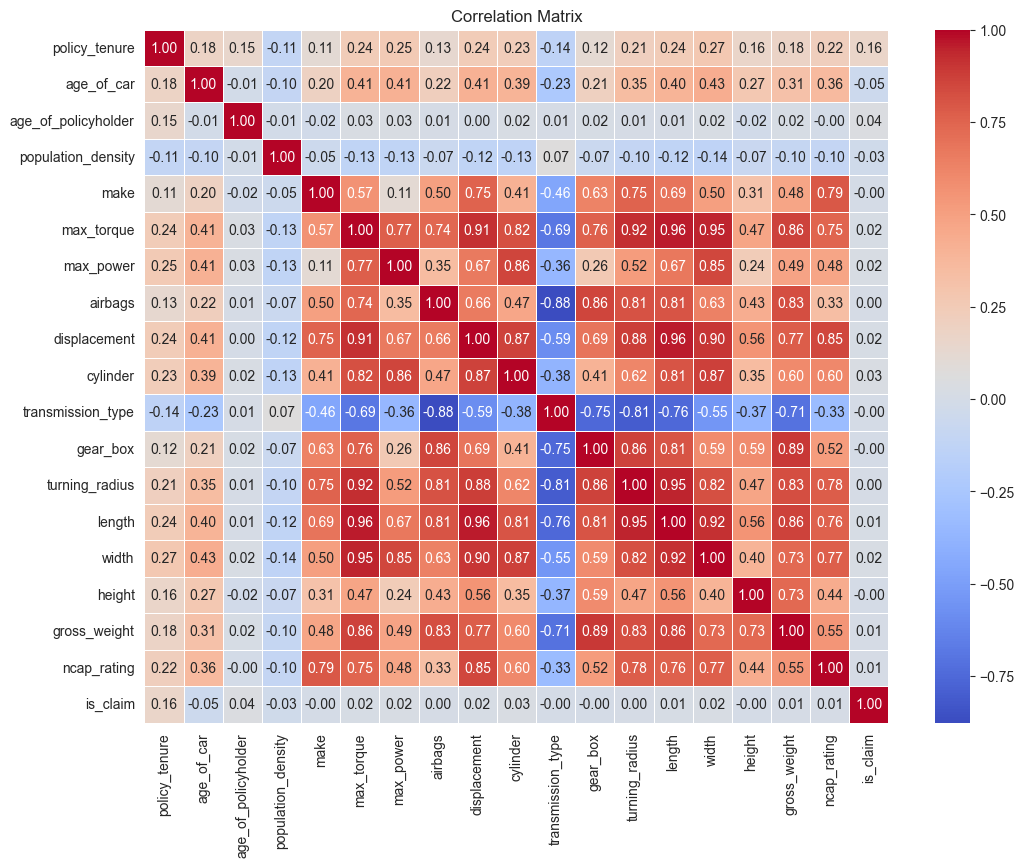

In [14]:

numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]

correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
corr_cols07 = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[j]
            corr_cols07.add(colname)


train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)
train_data_07 = train_data_numeric.drop(columns=corr_cols07)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

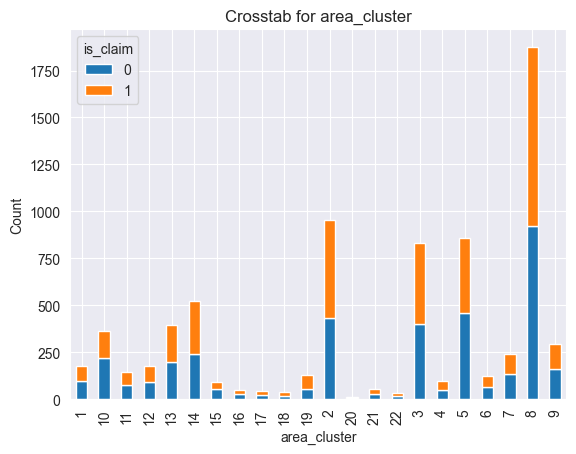

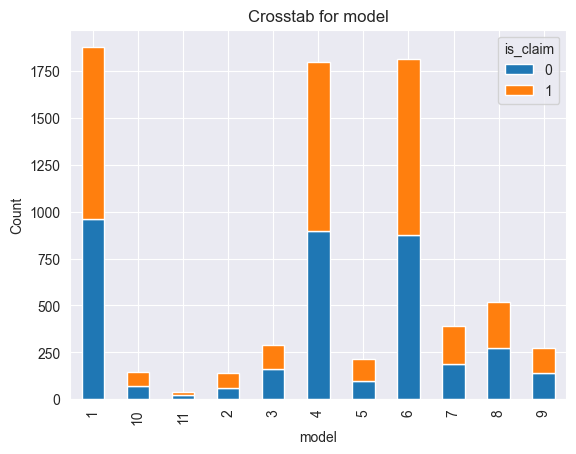

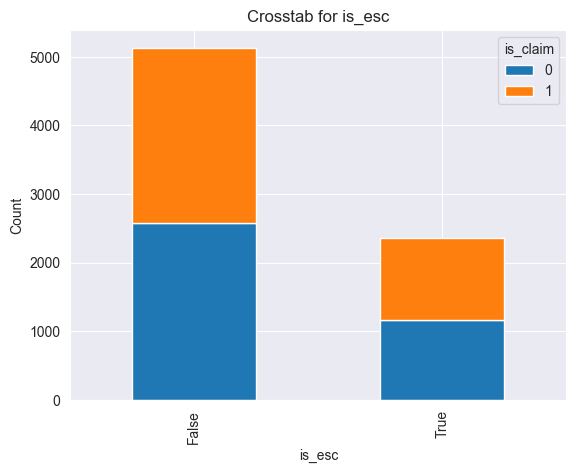

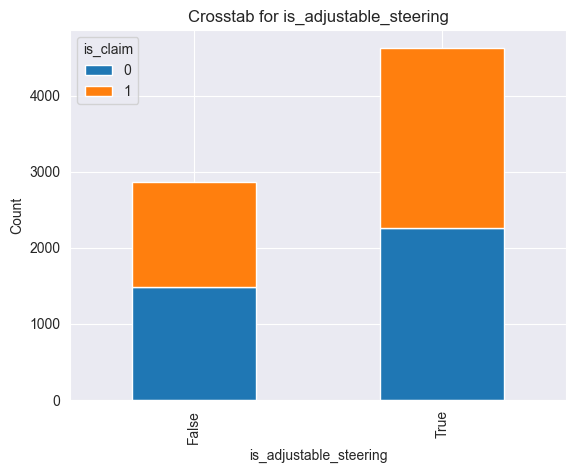

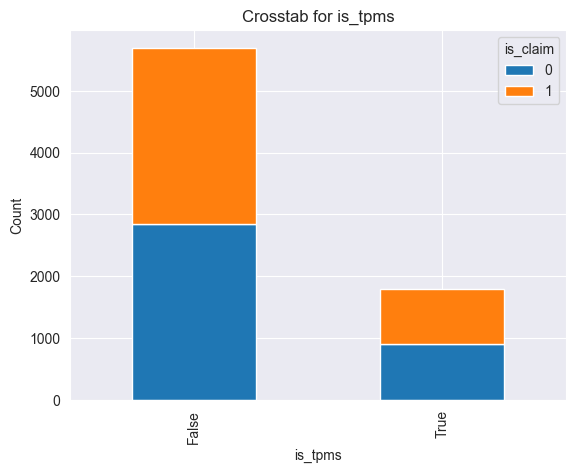

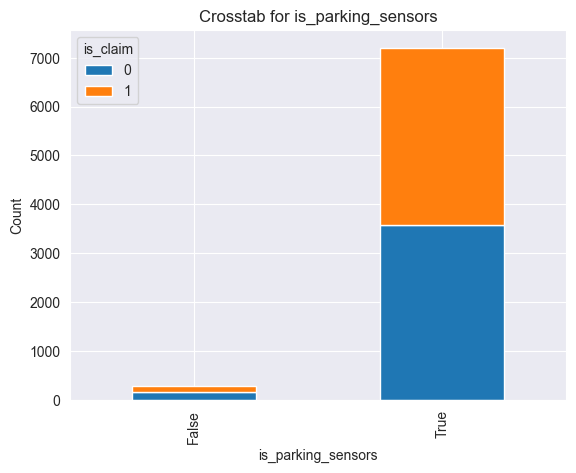

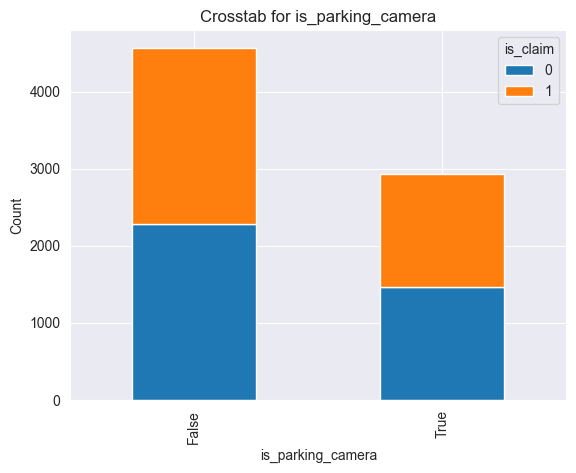

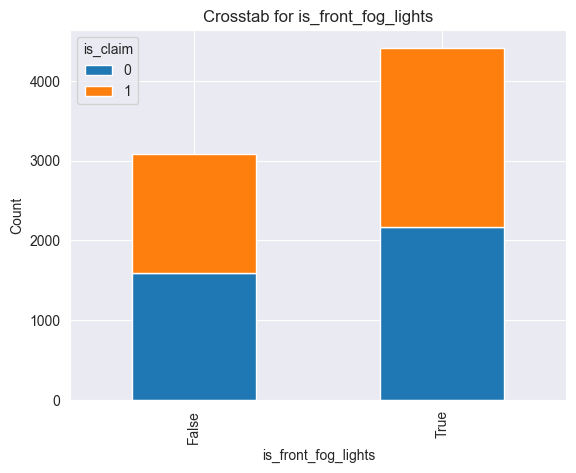

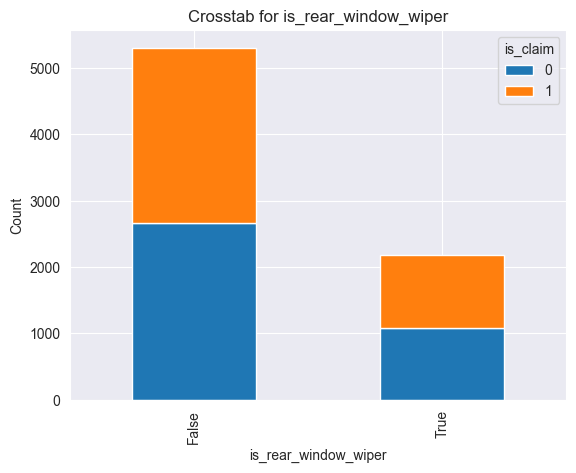

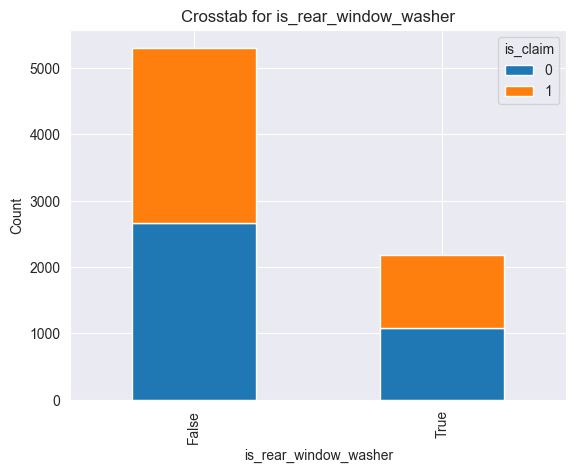

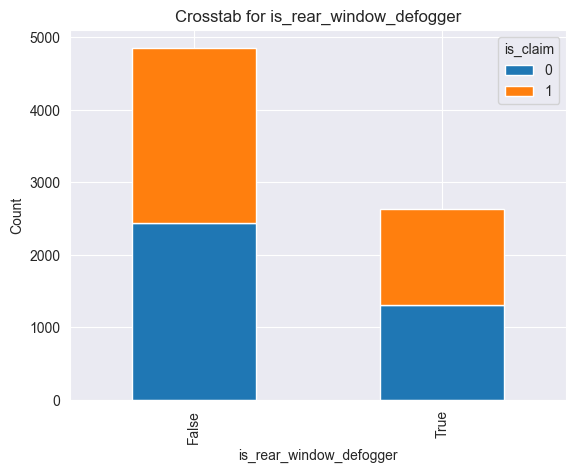

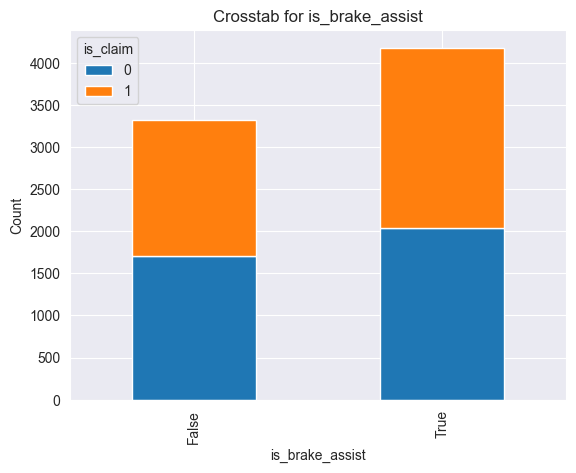

KeyboardInterrupt: 

In [13]:
non_numeric_columns = train_data.select_dtypes(exclude='number')

for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [5]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [7]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
        Classifier          Confusion Matrix  Precision    Recall  Accuracy   
0    Decision Tree  [[588, 530], [524, 607]]   0.531334  0.531347  0.531347  \
1    Decision Tree  [[587, 531], [505, 626]]   0.539310  0.539351  0.539351   
2    Decision Tree  [[595, 523], [511, 620]]   0.540216  0.540240  0.540240   
3    Decision Tree  [[579, 539], [521, 610]]   0.528643  0.528679  0.528679   
4    Decision Tree  [[590, 528], [523, 608]]   0.532670  0.532681  0.532681   
5   Neural Network  [[1104, 14], [1121, 10]]   0.456193  0.495331  0.495331   
6   Neural Network  [[469, 649], [467, 664]]   0.503404  0.503779  0.503779   
7   Neural Network  [[790, 328], [800, 331]]   0.499581  0.498444  0.498444   
8   Neural Network  [[1091, 27], [1097, 34]]   0.528173  0.500222  0.500222   
9   Neural Network  [[944, 174], [967, 164]]   0.489569  0.492663  0.492663   
10            K-NN  [[549, 569], [574, 557]]   0.491787  0.491774  0.491774   
11          

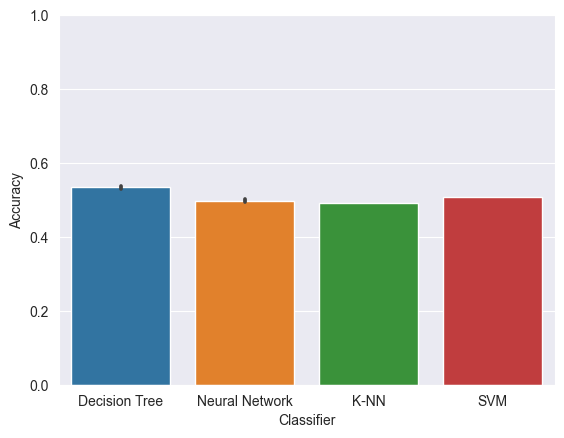

In [8]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    for _ in range(5):
        print(_)
        # Train the model
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Classifier': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

### Neural Network

We tested 4 sets:

- Default Set
- Set without more than 90% correlated information
- Set without more than 80% correlated information
- Set without more than 70% correlated information

With 3 division methods:

- Random division (70/30)
- Random division (80/20)
- Stratified folds (5 folds)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
                   Set          Confusion Matrix  Precision    Recall   
0          Default Set    [[1153, 2], [1093, 1]]   0.425787  0.513117  \
1          Default Set  [[71, 1059], [53, 1066]]   0.537287  0.505558   
2          Default Set    [[0, 1128], [0, 1121]]   0.750002  0.498444   
3          Default Set    [[1084, 0], [1165, 0]]   0.750324  0.481992   
4          Default Set   [[1115, 24], [1102, 8]]   0.378097  0.499333   
5   >= 0.9 correlation  [[28, 1094], [29, 1098]]   0.496081  0.500667   
6   >= 0.9 correlation    [[0, 1111], [0, 1138]]   0.750036  0.506003   
7   >= 0.9 correlation  [[385, 702], [380, 782]]   0.515506  0.518897   
8   >= 0.9 correlation    [[1123, 0], [1126, 0]]   0.750000  0.499333   
9   >= 0.9 correlation    [[0, 1142], [0, 1107]]   0.750061  0.492219   
10  >= 0.8 correlation    [[4, 1135], [4, 1106]]   0.496807  0.493553   
11  >= 0.8 correlation  [[729, 411], [693, 416]]   0.507907  0.509115   
12  >= 0.8 

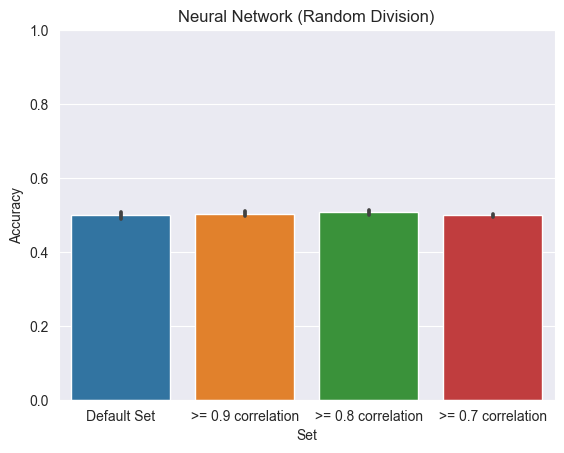

In [16]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []

for (name, data_set) in sets.items():
     # Train the model
     for _ in range(5): #running 5 times each
         print(_)
         neural_network = MLPClassifier()
         target_column = "is_claim"
         X = data_set.drop(target_column, axis=1)
         y = data_set[target_column]
         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
         start_time = time.time()

         neural_network.fit(X_train, y_train)
         train_time = time.time() - start_time

         # Test the model
         start_time = time.time()
         y_pred = neural_network.predict(X_test)
         test_time = time.time() - start_time

         # Calculate evaluation metrics
         conf_matrix = confusion_matrix(y_test, y_pred)
         precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
         recall = recall_score(y_test, y_pred, average='weighted')
         accuracy = accuracy_score(y_test, y_pred)
         f1 = f1_score(y_test, y_pred, average='weighted')

         # Store the results
         results.append({
            'Set' : name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
         })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
                   Set          Confusion Matrix  Precision    Recall   
0          Default Set      [[724, 4], [771, 1]]   0.337971  0.483333  \
1          Default Set     [[7, 716], [12, 765]]   0.445148  0.514667   
2          Default Set    [[44, 688], [38, 730]]   0.525436  0.516000   
3          Default Set      [[750, 6], [739, 5]]   0.479316  0.503333   
4          Default Set      [[5, 725], [5, 765]]   0.506890  0.513333   
5   >= 0.9 correlation  [[119, 605], [106, 670]]   0.527131  0.526000   
6   >= 0.9 correlation  [[233, 537], [198, 532]]   0.519705  0.510000   
7   >= 0.9 correlation      [[0, 735], [0, 765]]   0.750100  0.510000   
8   >= 0.9 correlation      [[766, 0], [734, 0]]   0.750114  0.510667   
9   >= 0.9 correlation      [[0, 766], [0, 734]]   0.750114  0.489333   
10  >= 0.8 correlation    [[733, 22], [723, 22]]   0.501728  0.503333   
11  >= 0.8 correlation  [[206, 548], [172, 574]]   0.528369  0.520000   
12  >= 0.8 

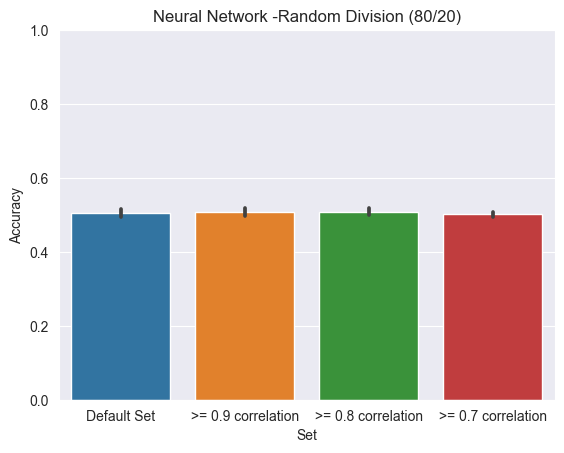

In [17]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []

for (name, data_set) in sets.items():
     # Train the model
     for _ in range(5): #running 5 times each
         print(_)
         neural_network = MLPClassifier()
         target_column = "is_claim"
         X = data_set.drop(target_column, axis=1)
         y = data_set[target_column]
         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
         start_time = time.time()

         neural_network.fit(X_train, y_train)
         train_time = time.time() - start_time

         # Test the model
         start_time = time.time()
         y_pred = neural_network.predict(X_test)
         test_time = time.time() - start_time

         # Calculate evaluation metrics
         conf_matrix = confusion_matrix(y_test, y_pred)
         precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
         recall = recall_score(y_test, y_pred, average='weighted')
         accuracy = accuracy_score(y_test, y_pred)
         f1 = f1_score(y_test, y_pred, average='weighted')

         # Store the results
         results.append({
            'Set' : name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
         })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set     [[737, 13], [742, 8]]   0.439631  0.496667  \
1          Default Set    [[91, 658], [66, 684]]   0.544629  0.517011   
2          Default Set      [[0, 749], [0, 750]]   0.750000  0.500334   
3          Default Set      [[0, 750], [0, 749]]   0.750000  0.499666   
4          Default Set      [[0, 750], [0, 749]]   0.750000  0.499666   
5   >= 0.9 correlation      [[0, 750], [0, 750]]   0.750000  0.500000   
6   >= 0.9 correlation    [[14, 735], [19, 731]]   0.461464  0.496998   
7   >= 0.9 correlation      [[0, 749], [0, 750]]   0.750000  0.500334   
8   >= 0.9 correlation      [[0, 750], [0, 749]]   0.750000  0.499666   
9   >= 0.9 correlation      [[750, 0], [749, 0]]   0.750000  0.500334   
10  >= 0.8 correlation    [[16, 734], [13, 737]]   0.526372  0.502000   
11  >= 0.8 correlation      [[3, 746], [5, 745]]   0.437374  0.498999   
12  >= 0.8 correlation  [[257, 492], [227, 523]]   

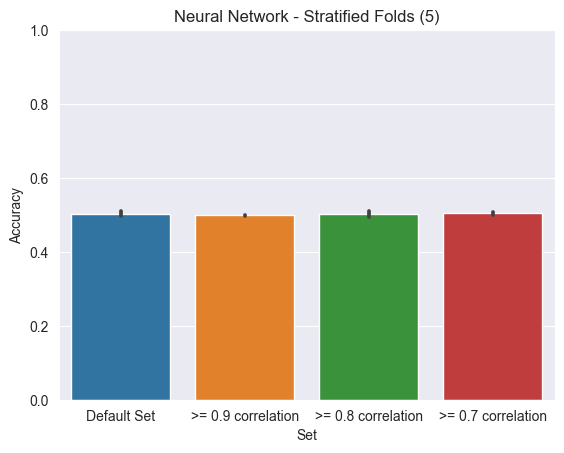

In [25]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []
skf = StratifiedKFold(n_splits=5)

for (name, data_set) in sets.items():
    neural_network = MLPClassifier()
    target_column = "is_claim"
    X = data_set.drop(target_column, axis=1)
    y = data_set[target_column]
    for train_index, test_index in skf.split(X, y):
        # Train the model
         X_train, X_test = X.values[train_index], X.values[test_index]
         y_train, y_test = y.values[train_index], y.values[test_index]
         start_time = time.time()

         neural_network.fit(X_train, y_train)
         train_time = time.time() - start_time

         # Test the model
         start_time = time.time()
         y_pred = neural_network.predict(X_test)
         test_time = time.time() - start_time

         # Calculate evaluation metrics
         conf_matrix = confusion_matrix(y_test, y_pred)
         precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
         recall = recall_score(y_test, y_pred, average='weighted')
         accuracy = accuracy_score(y_test, y_pred)
         f1 = f1_score(y_test, y_pred, average='weighted')

         # Store the results
         results.append({
            'Set' : name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
         })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (5)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()